In [1]:
#!pip install git+https://github.com/qubvel/segmentation_models

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import cv2
from tensorflow import keras
import numpy as np
import PIL
from IPython.display import Image, display
from PIL import ImageOps
import random
import re
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [3]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [4]:
def bgr_to_rgb(img):
    b,g,r = cv2.split(img)
    return cv2.merge([r,g,b])

In [5]:
def load_all_imgs(path, img_size, mode):
    imgs = []
    files = os.listdir(path)
    files.sort()
    print(f'\n{path} found {len(files)} img to load')
    for index, file in enumerate(files):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, mode)
        
        if mode == 0:
            img = np.expand_dims(img, 2)
        
        if mode == 1:
            img = bgr_to_rgb(img)
        img = cv2.resize(img, img_size)
        img = img / 255.
        imgs.append(img)
        if index % 100 == 0:
            print(f'\n[{index}]:', end='')
        else:
            print("|", end='')
    return np.array(imgs)

In [6]:
img_size = (224, 224)
img_shape = (224,224,3)
input_dir = "../dataset/segmentation/all_seg/"
target_dir = "../dataset/segmentation/annotation/all/"
num_classes = 1
batch_size = 10
epochs = 100

In [7]:
# Load images
trainImgs = load_all_imgs(input_dir,img_size, 1)
validImgs = load_all_imgs(target_dir,img_size, 0)


../dataset/segmentation/all_seg/ found 120 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||
../dataset/segmentation/annotation/all/ found 120 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||

In [8]:
img_to_test = int(len(trainImgs) * 0.8)
x_train = trainImgs[0:img_to_test]
y_train = validImgs[0:img_to_test]
x_val = trainImgs[img_to_test:]
y_val = validImgs[img_to_test:]
validation_data = (x_val, y_val)
print("ImgToTest:",img_to_test)
print("Validation_data_size:", len(validation_data[0]))

ImgToTest: 96
Validation_data_size: 24


In [9]:
keras.backend.clear_session()

In [10]:
model = sm.Unet(input_shape=img_shape, classes=1, encoder_freeze=True)
model.compile('Adam',loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

2021-11-24 20:22:15.136856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 20:22:15.142185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 20:22:15.142518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 20:22:15.143663: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
pred = model.predict(x_train)

2021-11-24 20:22:16.098124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-24 20:22:16.615701: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-11-24 20:22:17.634970: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-24 20:22:17.635046: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-24 20:22:17.738842: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying t

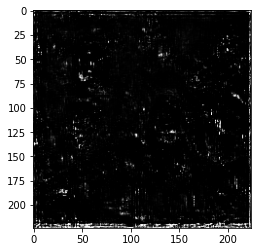

In [12]:
plt.imshow(pred[80], cmap='gray')

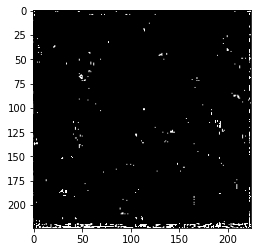

In [13]:
from matplotlib.colors import NoNorm
predict_img = pred[80]
predict_img[predict_img > 0.5] = 1
predict_img[predict_img <= 0.5] = 0

plt.imshow(predict_img, cmap='gray', norm=NoNorm())

In [14]:
model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs, validation_data=validation_data)

Epoch 1/100


2021-11-24 20:22:33.085129: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


10/10 [==============================] - 19s 1s/step - loss: 1.2436 - iou_score: 0.3230 - val_loss: 1.4155 - val_iou_score: 0.2554
Epoch 2/100
10/10 [==============================] - 3s 311ms/step - loss: 0.8991 - iou_score: 0.4809 - val_loss: 1.4428 - val_iou_score: 0.3593
Epoch 3/100
10/10 [==============================] - 3s 311ms/step - loss: 0.7633 - iou_score: 0.5667 - val_loss: 1.3956 - val_iou_score: 0.4774
Epoch 4/100
10/10 [==============================] - 3s 312ms/step - loss: 0.6909 - iou_score: 0.6120 - val_loss: 2.0034 - val_iou_score: 0.1510
Epoch 5/100
10/10 [==============================] - 3s 316ms/step - loss: 0.6361 - iou_score: 0.6428 - val_loss: 1.1435 - val_iou_score: 0.3853
Epoch 6/100
10/10 [==============================] - 3s 315ms/step - loss: 0.5992 - iou_score: 0.6633 - val_loss: 1.0632 - val_iou_score: 0.4215
Epoch 7/100
10/10 [==============================] - 3s 312ms/step - loss: 0.5646 - iou_score: 0.6842 - val_loss: 1.0011 - val_iou_score: 0.4514

10/10 [==============================] - 3s 311ms/step - loss: 0.1652 - iou_score: 0.9063 - val_loss: 1.2483 - val_iou_score: 0.5293
Epoch 58/100
10/10 [==============================] - 3s 305ms/step - loss: 0.1681 - iou_score: 0.9048 - val_loss: 1.2587 - val_iou_score: 0.5294
Epoch 59/100
10/10 [==============================] - 3s 321ms/step - loss: 0.1699 - iou_score: 0.9027 - val_loss: 1.2600 - val_iou_score: 0.5334
Epoch 60/100
10/10 [==============================] - 3s 319ms/step - loss: 0.1687 - iou_score: 0.9037 - val_loss: 1.2369 - val_iou_score: 0.5335
Epoch 61/100
10/10 [==============================] - 3s 341ms/step - loss: 0.1642 - iou_score: 0.9065 - val_loss: 1.2504 - val_iou_score: 0.5373
Epoch 62/100
10/10 [==============================] - 3s 320ms/step - loss: 0.1545 - iou_score: 0.9103 - val_loss: 1.2658 - val_iou_score: 0.5369
Epoch 63/100
10/10 [==============================] - 3s 322ms/step - loss: 0.1542 - iou_score: 0.9112 - val_loss: 1.2646 - val_iou_score

In [15]:
def plot_result(img_pred, original, valid):
    plt.figure(figsize=(10, 10))
    n = 1
    for index, img in enumerate(img_pred):
        for i in range(3):
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.subplot(img_pred.shape[0] , 3, n)
            if i == 0:
                original_img = cv2.resize(original[index], img_size)
                plt.imshow(original_img)
                plt.xlabel("Original ")
            if i == 1:
                result_img = cv2.resize(img, img_size)
                plt.imshow(result_img, cmap=plt.cm.binary)
                plt.xlabel("Result", )
            if i == 2:
                valid_img = cv2.resize(valid[index], img_size)
                plt.imshow(valid_img, cmap=plt.cm.binary)
                plt.xlabel("Expected")
            n += 1


../dataset/segmentation/healthy/ found 30 img to load

[0]:|||||||||||||||||||||||||||||
../dataset/segmentation/annotation/healthy/ found 30 img to load

[0]:|||||||||||||||||||||||||||||

2021-11-24 20:28:02.576347: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-24 20:28:02.576418: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


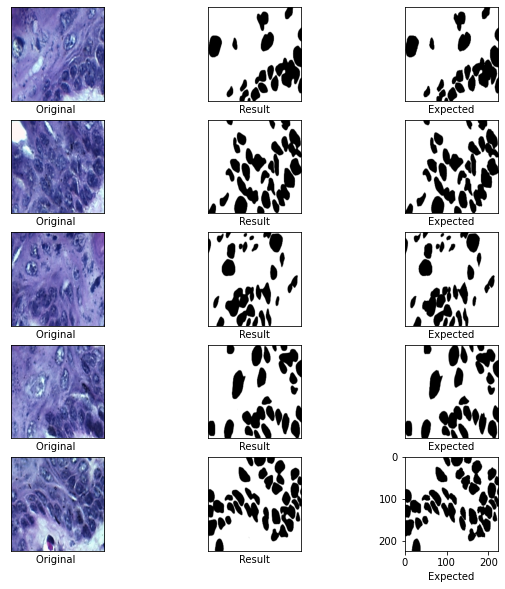

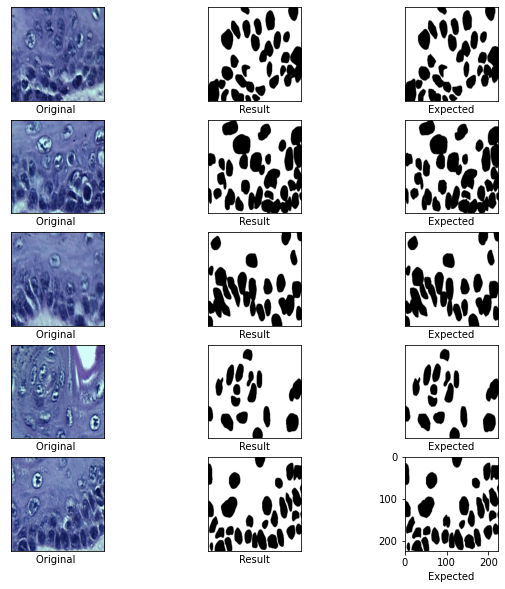

In [16]:
path_healthy_img = '../dataset/segmentation/healthy/'
path_healthy_val = '../dataset/segmentation/annotation/healthy/'

healthy_img = load_all_imgs(path_healthy_img, img_size, 1)
healthy_val = load_all_imgs(path_healthy_val, img_size, 0)
healthy_pred = model.predict(healthy_img)
# ----- Primeiras 5 Imagens -----
plot_result(healthy_pred[:5], healthy_img[:5], healthy_val[:5])
# ----- Ultimas 5 Imagens -----
plot_result(healthy_pred[-5:], healthy_img[-5:], healthy_val[-5:])